<a href="https://colab.research.google.com/github/RegiTelma/ComputerVision/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers

In [2]:
(dataset_train_original,dataset_validate_original), info= tfds.load(
    "cats_vs_dogs",
    split=["train[:10%]","train[90%:]"], #Pretend to have a small dataset!
    as_supervised=True,
    with_info=True
)
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteILY9JF/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path=PosixGPath('/tmp/tmpbvpejwk0tfds'),
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
  

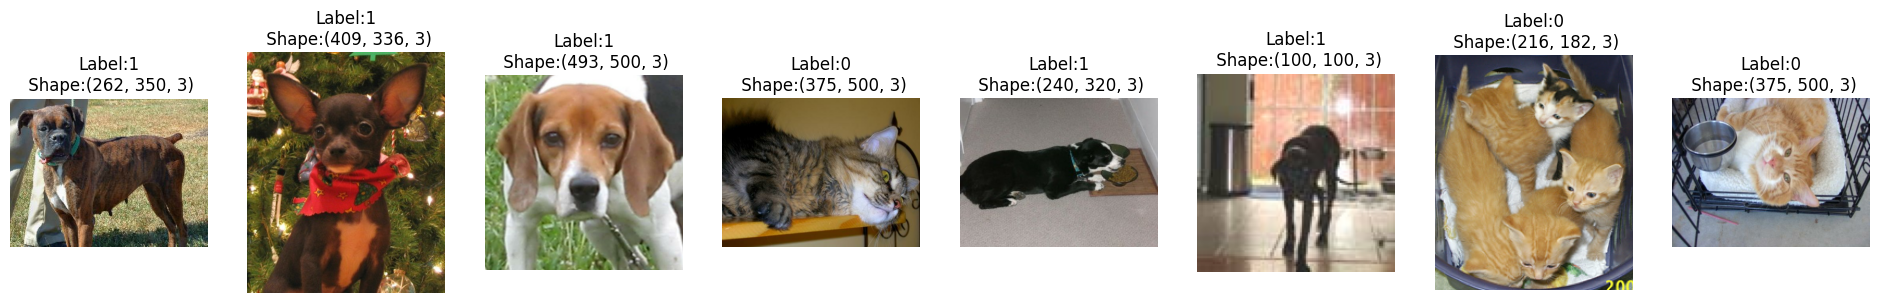

In [3]:
num_samples=8
index=1
plt.figure(figsize=(24,4))
for image,label in dataset_train_original.take(num_samples):
  plt.subplot(1,num_samples,index)
  plt.imshow(image)
  plt.title(f"Label:{label}\n Shape:{image.shape}")
  plt.axis("off")
  index+=1

Aspect Ratio-we made it a square- hence 1

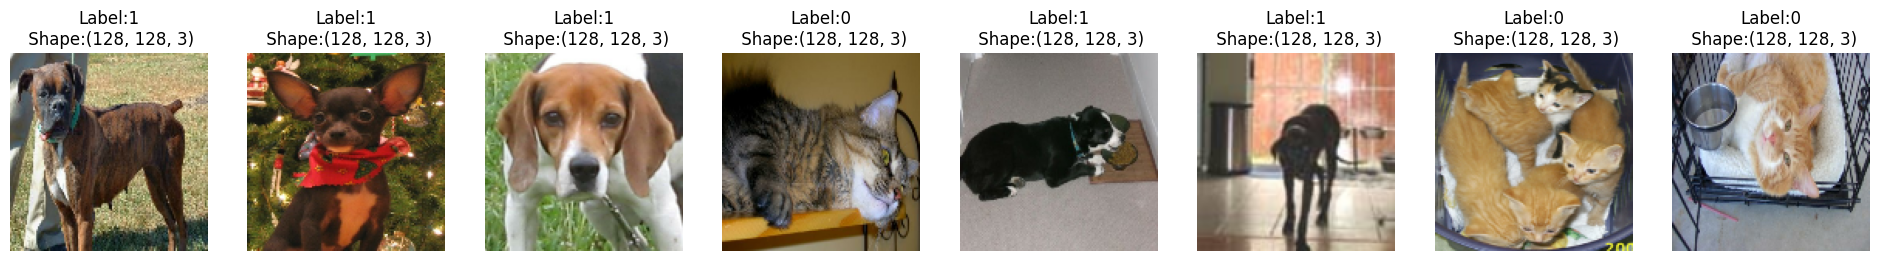

In [4]:
def encode(image,label,image_size=(128,128)): #Parameter!
  image=tf.image.convert_image_dtype(image,tf.float32)
  image=tf.image.resize(image,image_size)
  return image,label

dataset=dataset_train_original.map(lambda image,label:encode(image,label))

num_samples=8
index=1
plt.figure(figsize=(24,4))
for image,label in dataset.take(num_samples):
  plt.subplot(1,num_samples,index)
  plt.imshow(image)
  plt.title(f"Label:{label}\n Shape:{image.shape}")
  plt.axis("off")
  index+=1

Pipelines

In [5]:
dataset_train=dataset_train_original.map(lambda image,label:encode(image,label))
dataset_train=dataset_train.cache()
dataset_train=dataset_train.shuffle(2500)
dataset_train=dataset_train.batch(128)

dataset_validate=dataset_validate_original.map(lambda image,label:encode(image,label))
dataset_validate=dataset_validate.cache()
dataset_validate=dataset_validate.batch(128)

In [6]:
history_list={}
epochs=50

In [7]:
def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["accuracy"], label="accuracy")
    plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Our accuracies")
    plt.show()
    plt.close()

def compare_histories():
    for training_name, history in history_list.items():
        plt.plot(history["val_accuracy"], label=training_name)
    plt.legend()
    plt.title("Comparison of val_accuracy")
    plt.show()
    plt.close()

#Training a CNN from scratch

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0

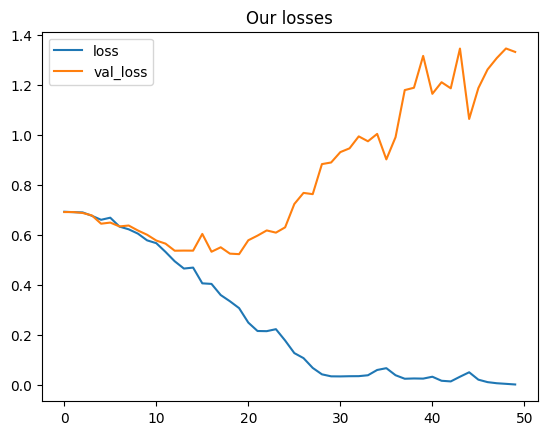

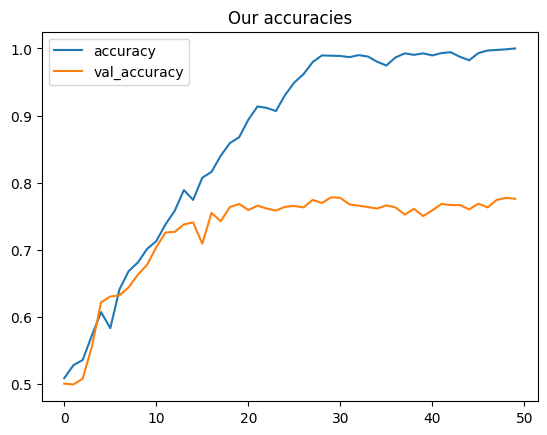

<function __main__.compare_histories()>

In [8]:
model=models.Sequential()

model.add(layers.Conv2D(32,(3,3),padding="same",activation="relu",input_shape=(128,128,3))) #Filter is 32
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32,(3,3),padding="same",activation="relu"))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32,(3,3),padding="same",activation="relu"))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64,(3,3),padding="same",activation="relu"))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64,(3,3),padding="same",activation="relu"))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128,(3,3),padding="same",activation="relu"))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())

#model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dense(1,activation="sigmoid"))

model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history=model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_validate
)

history_list["baseline"]=history.history
render_history(history.history)
compare_histories

In [9]:
3*3*3*32+32   #(3,3)-kernel size,3-channels,32-filters

896

#Data Augmentation

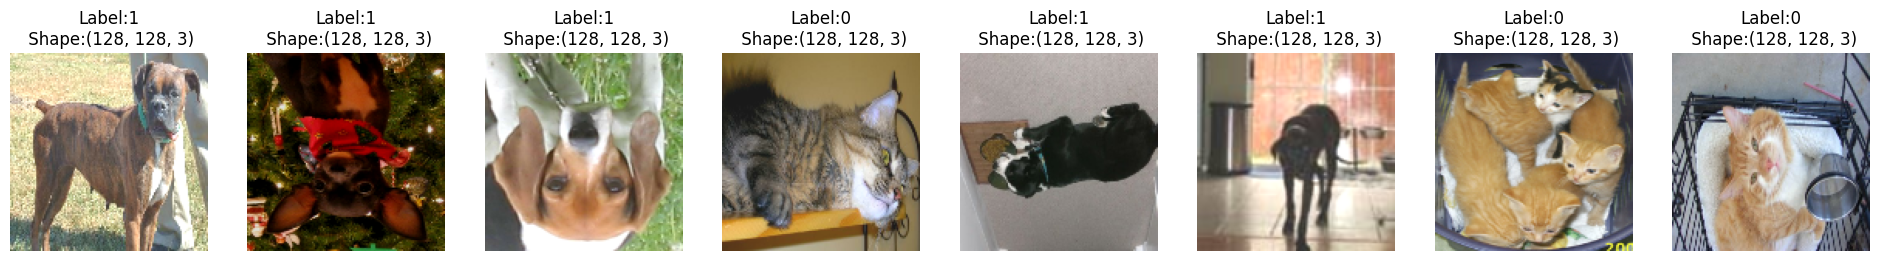

In [10]:
def augment(image,label):
  image_augmented=image
  #TODO
  image_augmented=tf.image.random_flip_left_right(image_augmented) #flip
  image_augmented=tf.image.random_flip_up_down(image_augmented)
  image_augmented=tf.image.random_brightness(image_augmented,max_delta=0.2)
  return image_augmented,label

dataset=dataset_train_original.map(lambda image,label:encode(image,label))
dataset=dataset.map(lambda image,label:augment(image,label))

num_samples=8
index=1
plt.figure(figsize=(24,4))
for image,label in dataset.take(num_samples):
  plt.subplot(1,num_samples,index)
  plt.imshow(image)
  plt.title(f"Label:{label}\n Shape:{image.shape}")
  plt.axis("off")
  index+=1

In [11]:
dataset_train_augmented=dataset_train_original.map(lambda image,label:encode(image,label))
dataset_train_augmented=dataset_train_augmented.cache()
dataset_train_augmented=dataset_train_augmented.map(lambda image,label:encode(image,label))
dataset_train_augmented=dataset_train_augmented.shuffle(2500)
dataset_train_augmented=dataset_train_augmented.batch(128)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

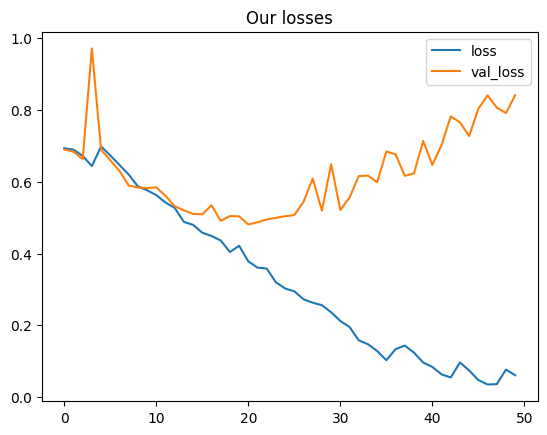

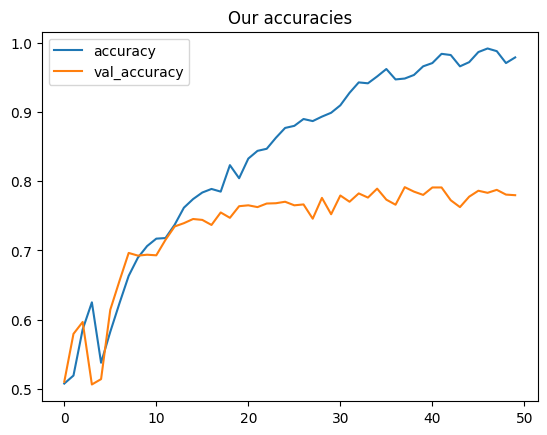

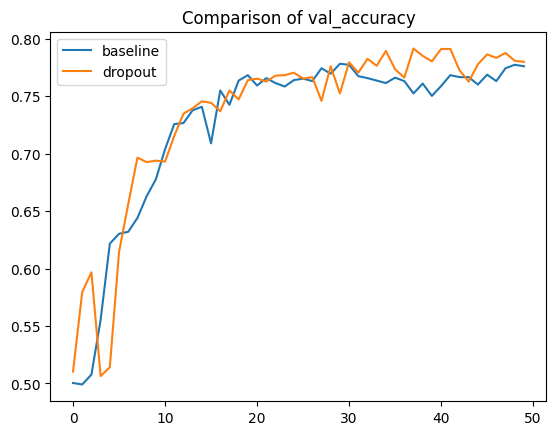

In [12]:
tf.keras.backend.clear_session()

model=models.Sequential()

model.add(layers.Conv2D(32,(3,3),padding="same",activation="relu",input_shape=(128,128,3))) #Filter is 32
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32,(3,3),padding="same",activation="relu"))
model.add(layers.MaxPooling2D(2,2))

#model.add(layers.Conv2D(32,(3,3),padding="same",activation="relu"))
#model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64,(3,3),padding="same",activation="relu"))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64,(3,3),padding="same",activation="relu"))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128,(3,3),padding="same",activation="relu"))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())

#model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dense(1,activation="sigmoid"))
model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train_augmented,
    epochs=epochs,
    validation_data=dataset_validate
)

history_list["dropout"] = history.history
render_history(history.history)
compare_histories()

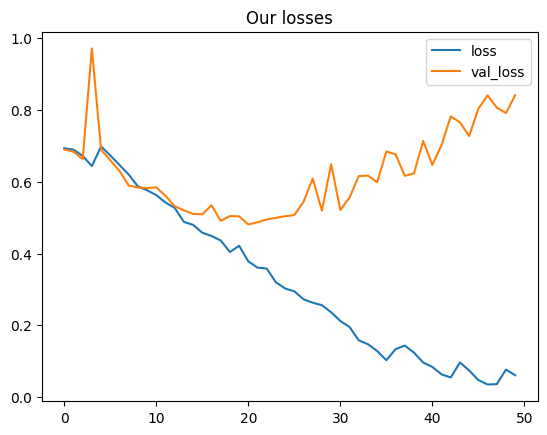

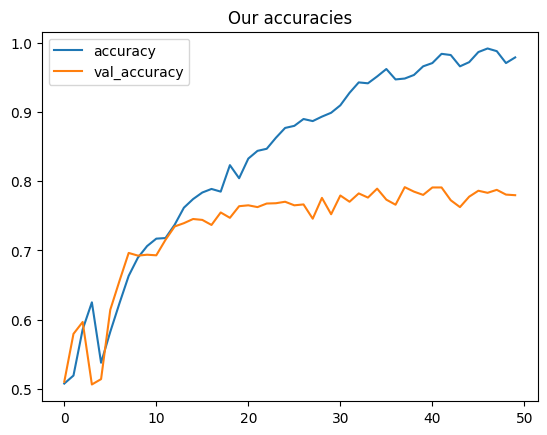

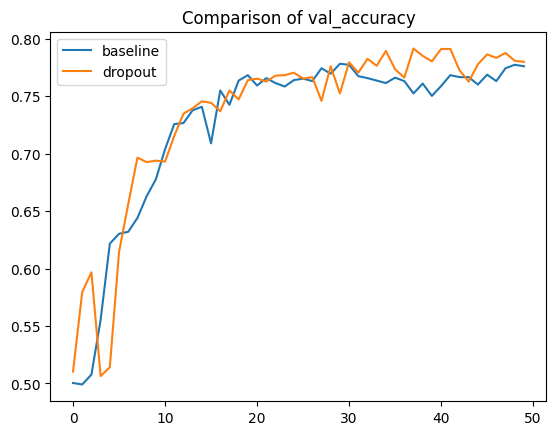

In [13]:
history_list["dropout"] = history.history
render_history(history.history)
compare_histories()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 32)        0

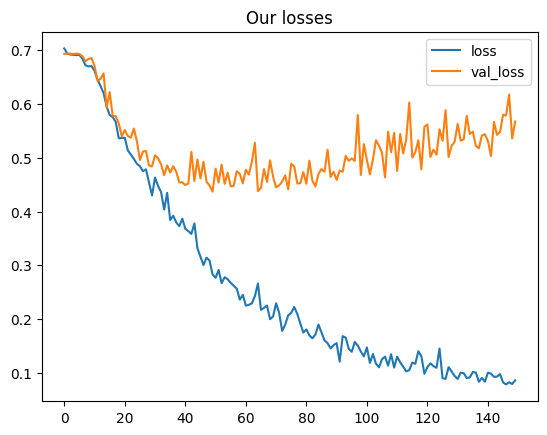

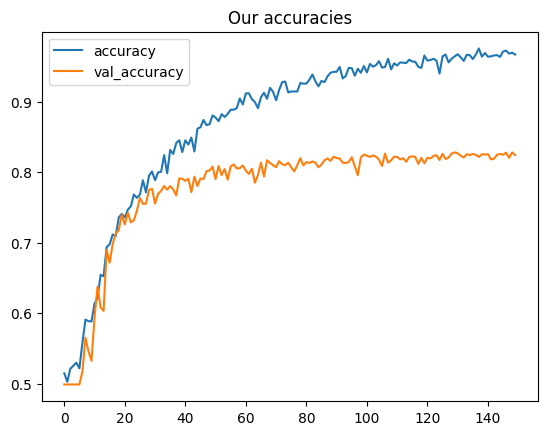

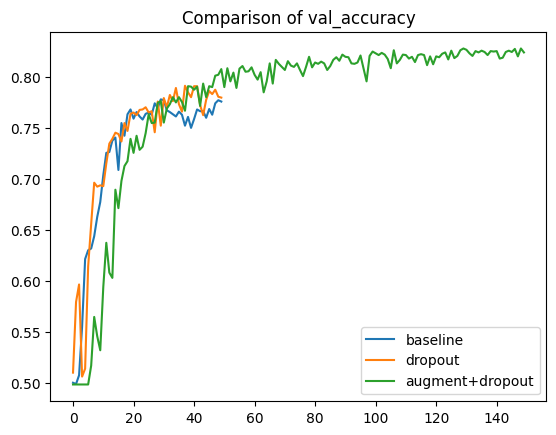

In [14]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.30))
model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.35))
model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.40))
model.add(layers.Conv2D(128, (3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.45))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.50))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train_augmented,
    epochs=epochs+100,
    validation_data=dataset_validate
)

history_list["augment+dropout"] = history.history
render_history(history.history)
compare_histories()

#Transfer Learning

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15,763,521
Trainable params: 1,048,833
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/50
19/19 [==============================] - 6s 150ms/step - loss: 0.5854 - accuracy: 0.7399 - v

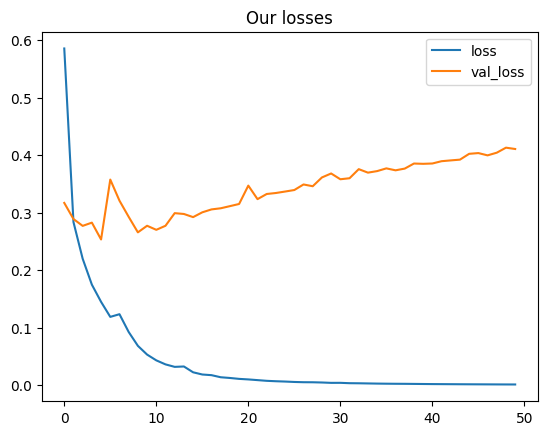

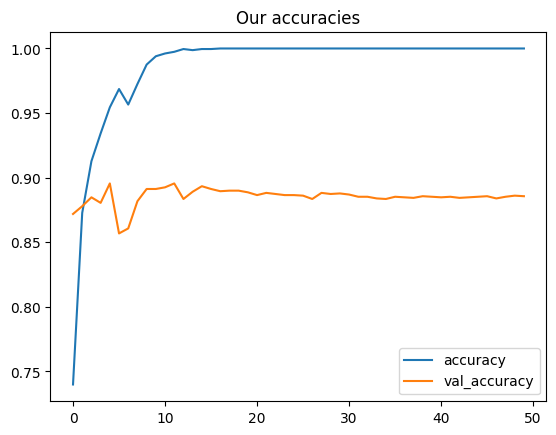

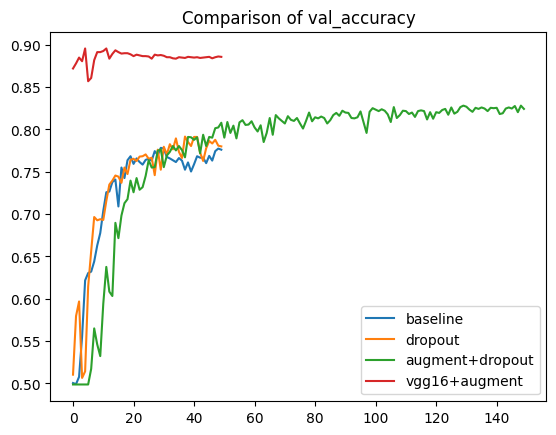

In [15]:
tf.keras.backend.clear_session()

base_net=tf.keras.applications.VGG16(
    input_shape=(128,128,3),
    include_top=False
)
base_net.trainable=False
#base_net.summary()

model=models.Sequential()
model.add(base_net)
model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dense(1,activation="sigmoid"))

model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train_augmented,
    epochs=epochs,
    validation_data=dataset_validate
)

history_list["vgg16+augment"] = history.history
render_history(history.history)
compare_histories()

14million pictures, 1000 classes, trained network

Backpropagation

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2

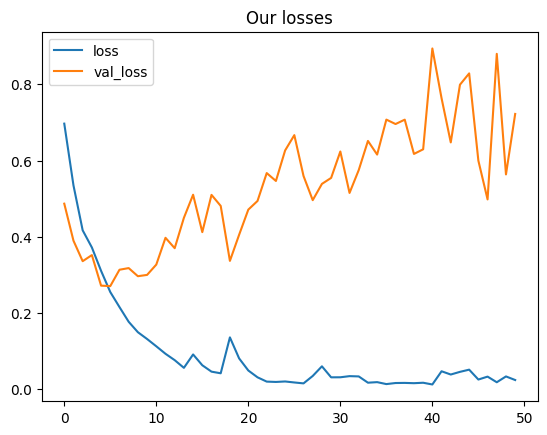

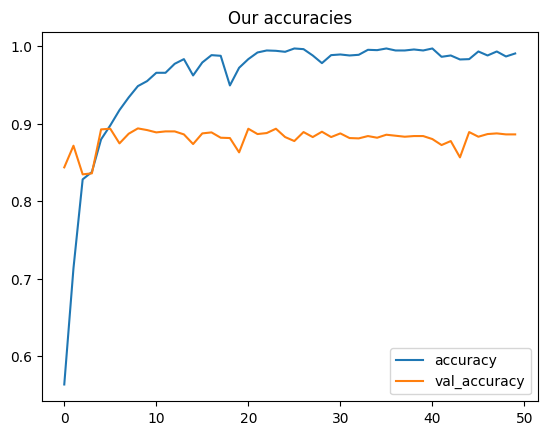

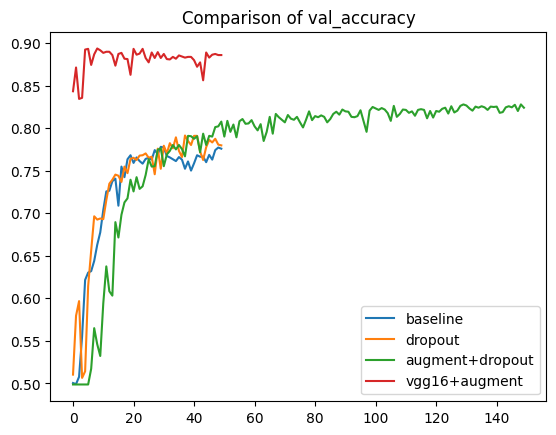

In [16]:
tf.keras.backend.clear_session()

base_net=tf.keras.applications.VGG16(
    input_shape=(128,128,3),
    include_top=False
)
base_net.trainable=False
#base_net.summary()

model=models.Sequential()
model.add(base_net)
model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64,activation="relu"))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(32,activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation="sigmoid"))

model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train_augmented,
    epochs=epochs,
    validation_data=dataset_validate
)

history_list["vgg16+augment"] = history.history
render_history(history.history)
compare_histories()

#VGG19

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                         

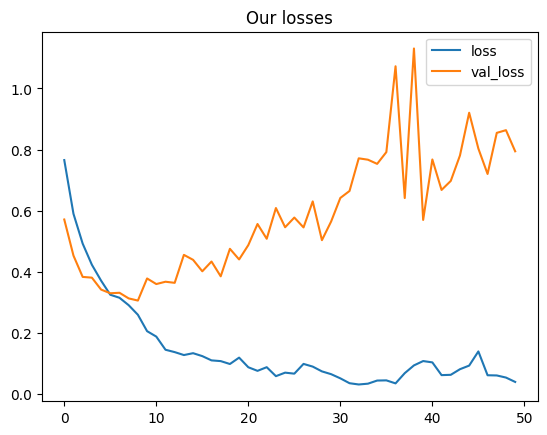

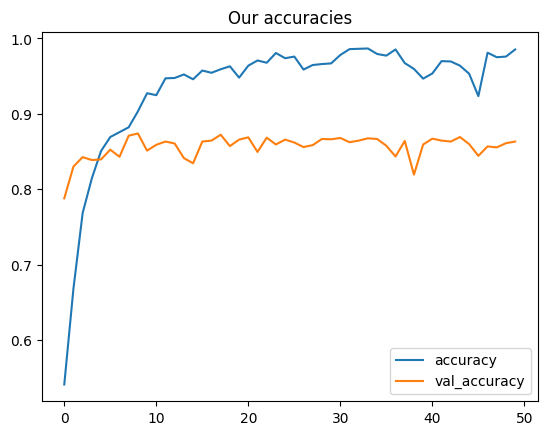

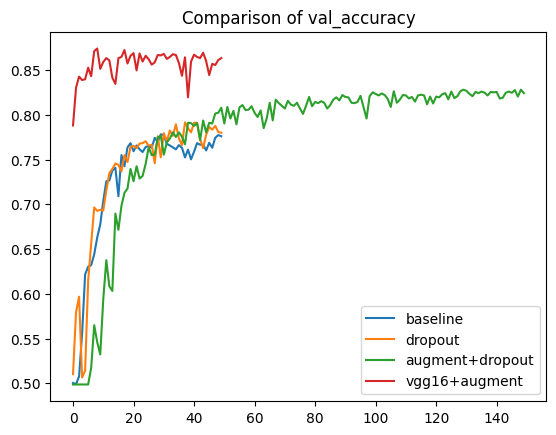

In [17]:
tf.keras.backend.clear_session()

base_net=tf.keras.applications.VGG19(
    input_shape=(128,128,3),
    include_top=False
)
base_net.trainable=False
#base_net.summary()

model=models.Sequential()
model.add(base_net)
model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64,activation="relu"))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(32,activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation="sigmoid"))

model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train_augmented,
    epochs=epochs,
    validation_data=dataset_validate
)

history_list["vgg16+augment"] = history.history
render_history(history.history)
compare_histories()

#NASNetLarge

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 4, 4, 4032)        84916818  
                                                                 
 flatten (Flatten)           (None, 64512)             0         
                                                                 
 dense (Dense)               (None, 128)               8257664   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2

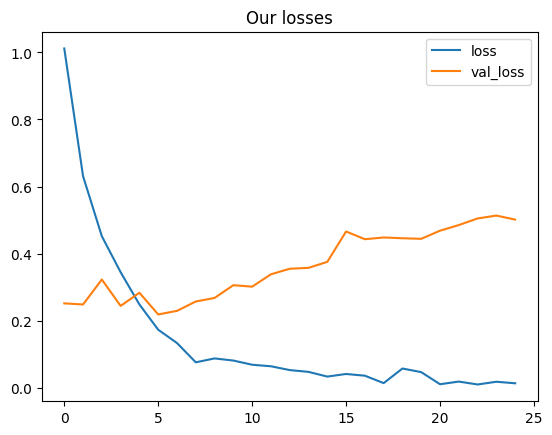

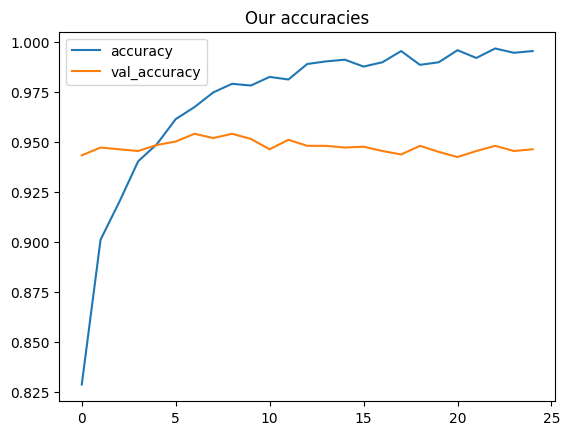

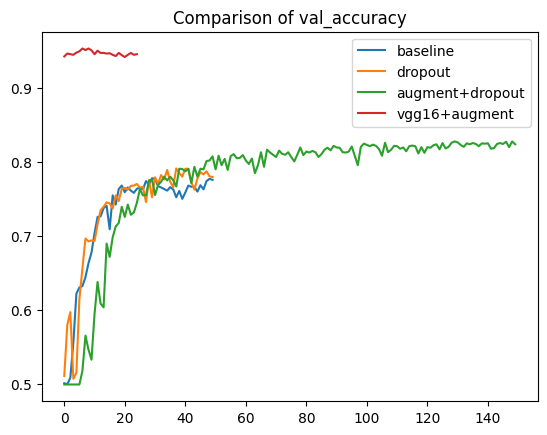

In [25]:
tf.keras.backend.clear_session()

base_net=tf.keras.applications.NASNetLarge(
    input_shape=(128,128,3),
    include_top=False
)
base_net.trainable=False
#base_net.summary()

model=models.Sequential()
model.add(base_net)
model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64,activation="relu"))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(32,activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation="sigmoid"))

model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train_augmented,
    epochs=epochs-25,
    validation_data=dataset_validate
)

history_list["vgg16+augment"] = history.history
render_history(history.history)
compare_histories()

In [22]:
tf.keras.utils.plot_model(
    base_net,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)
